In [ ]:
from google.colab import files  # Only works in Google Colab

uploaded = files.upload()

# Access the file
for filename in uploaded.keys():
    print(f"Uploaded file: {filename}")

KeyboardInterrupt: 

In [ ]:
import numpy as np
import pandas as pd

# Adjust filename as needed
filename = "10.csv"
df = (pd.read_excel(filename) if filename.endswith('.xlsx')
      else pd.read_csv(filename))

# Normalize column names: lowercase, strip, replace spaces with underscores
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

# Quick check
print("Columns:", df.columns.tolist())


Columns: ['timestamp', 'gaze_x', 'gaze_y', 'eye_aspect_ratio', 'blink', 'saccade_velocity', 'fixation', 'pupil_size', 'left_pupil_x', 'left_pupil_y', 'left_pupil_diameter', 'right_pupil_x', 'right_pupil_y', 'right_pupil_diameter', 'por_binocular_x', 'por_binocular_y', 'point_of_regard_right_x', 'point_of_regard_right_y', 'point_of_regard_left_x', 'point_of_regard_left_y', 'category_binocular', 'index_binocular']


In [ ]:
# Apply a 5‑sample median filter (~20 ms) to reduce jitter
df['gx_med'] = df['por_binocular_x'].rolling(window=5, center=True, min_periods=1).median()
df['gy_med'] = df['por_binocular_y'].rolling(window=5, center=True, min_periods=1).median()

# Optional: peek at first rows
print(df[['por_binocular_x','gx_med','por_binocular_y','gy_med']].head(10))


   por_binocular_x  gx_med  por_binocular_y  gy_med
0           878.75  878.75           634.25  634.00
1           878.50  878.75           633.00  633.50
2           878.75  878.75           634.00  633.25
3           879.00  878.75           631.50  633.25
4           876.50  878.75           633.25  633.25
5           878.75  878.75           634.75  632.00
6           879.00  878.75           631.50  633.00
7           877.50  879.00           632.00  633.00
8           880.25  880.00           633.00  632.00
9           880.00  880.25           633.25  632.00


/tmp/ipython-input-27-1800492385.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['saccade_velocity'].fillna(0, inplace=True)


<Axes: >

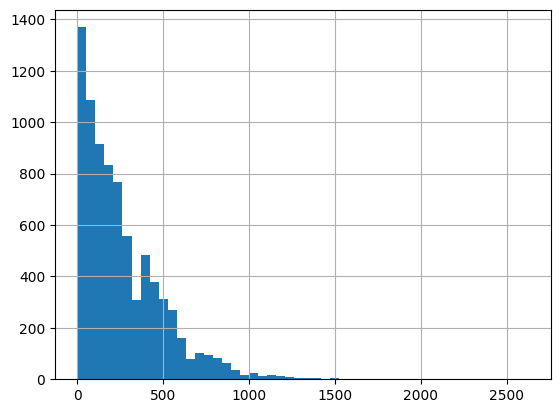

In [ ]:
# Compute delta positions & times
dx = df['gx_med'].diff()
dy = df['gy_med'].diff()
dt = df['timestamp'].diff()         # timestamp already in seconds

# Avoid divide‑by‑zero
dt = dt.replace(0, np.nan)

# Velocity (px/sec)
df['saccade_velocity'] = np.sqrt(dx**2 + dy**2) / dt
df['saccade_velocity'].fillna(0, inplace=True)

# Quick histogram to guide threshold choice
df['saccade_velocity'].hist(bins=50)


In [ ]:
# Parameters: you can tune these
VEL_THRESH = 500    # px/sec
DUR_THRESH = 0.02   # seconds

# Initial saccade mask
sv_mask = df['saccade_velocity'] > VEL_THRESH

# Label contiguous runs
df['sv_grp'] = (sv_mask != sv_mask.shift(1)).cumsum()

# Compute run durations
grp_stats = df.groupby('sv_grp').agg(
    is_saccade=('sv_grp','size'),
    start_time=('timestamp','first'),
    end_time=('timestamp','last')
)
grp_stats['duration'] = grp_stats['end_time'] - grp_stats['start_time']

# Identify short saccade groups
short_grps = grp_stats[(grp_stats['is_saccade']>0) &
                       (grp_stats['duration'] < DUR_THRESH)].index

# Zero‑out micro‑saccades
df.loc[df['sv_grp'].isin(short_grps), 'saccade_velocity'] = 0


In [ ]:
# Initialize
df['category_binocular'] = 'uncategorized'

# Blink: low velocity OR explicit blink flag
blink_mask = (df['saccade_velocity'] < 10) | (df['blink'] != 0)
df.loc[blink_mask, 'category_binocular'] = 'blink'

# Saccade: high velocity & not blink
saccade_mask = (df['saccade_velocity'] > VEL_THRESH) & (~blink_mask)
df.loc[saccade_mask, 'category_binocular'] = 'saccade'

# Visual intake: everything else
visual_intake_mask = ~(blink_mask | saccade_mask)
df.loc[visual_intake_mask, 'category_binocular'] = 'visual intake'

# Preview
print(df[['timestamp','saccade_velocity','blink','category_binocular']].head(30))


    timestamp  saccade_velocity  blink category_binocular
0       0.000          0.000000      0              blink
1       0.004        125.000000      0      visual intake
2       0.008         62.500000      0      visual intake
3       0.012          0.000000      0              blink
4       0.016          0.000000      0              blink
5       0.020        312.500000      0      visual intake
6       0.024        250.000000      0      visual intake
7       0.028         62.500000      0      visual intake
8       0.032        353.553391      0      visual intake
9       0.036         62.500000      0      visual intake
10      0.040        187.500000      0      visual intake
11      0.044        455.006868      0      visual intake
12      0.048        279.508497      0      visual intake
13      0.052        257.694102      0      visual intake
14      0.056        125.000000      0      visual intake
15      0.060        139.754249      0      visual intake
16      0.064 

In [ ]:
import pandas as pd

# Example: Assuming your DataFrame is named df

# Create 'RecordingTime [ms]' by subtracting the first timestamp
df['RecordingTime [ms]'] = df['timestamp'] - df['timestamp'].iloc[0]

# Display the updated DataFrame
print(df.head())

   timestamp      gaze_x      gaze_y  eye_aspect_ratio  blink  \
0      0.000  877.583333  626.916667          0.306073      0   
1      0.004  877.166667  626.083333          0.282213      0   
2      0.008  878.583333  625.833333          0.304156      0   
3      0.012  878.416667  624.666667          0.295823      0   
4      0.016  875.666667  626.750000          0.266089      0   

   saccade_velocity  fixation  pupil_size  left_pupil_x  left_pupil_y  ...  \
0               0.0         0  196.041371        1105.0         625.0  ...   
1             125.0         0  192.264363        1101.5         623.5  ...   
2              62.5         0  195.871324        1102.5         625.5  ...   
3               0.0         0  196.432556        1106.0         621.0  ...   
4               0.0         0  194.264807        1098.5         626.5  ...   

   point_of_regard_right_x  point_of_regard_right_y  point_of_regard_left_x  \
0                    652.5                    643.5          

In [ ]:
print("Counts:")
print("  Blinks:       ", (df['category_binocular']=='blink').sum())
print("  Saccades:     ",(df['category_binocular']=='saccade').sum())
print("  Visual intake:",(df['category_binocular']=='visual intake').sum())

# Save processed data (Colab) or local file
output = "processed_eye_data.csv"
df.to_csv(output, index=False)
print(f"Saved to {output}")


Counts:
  Blinks:        3786
  Saccades:      19
  Visual intake: 4214
Saved to processed_eye_data.csv


In [ ]:
from google.colab import files

# Save processed data
df.to_csv('processed_eye_data.csv', index=False)

# Download
files.download('processed_eye_data.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>